In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

def preprocess_for_naive_bayes(df):
    """
    Preprocesamiento específico para modelos Naive Bayes
    """
    processed_df = df.copy()
    
    # 1. Codificación de variables categóricas con LabelEncoder
    categorical_columns = [
        'feature-Method', 'feature-Protocol', 'feature-Connection'
    ]
    
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        processed_df[col + '_encoded'] = le.fit_transform(processed_df[col])
        label_encoders[col] = le
    
    # 2. Procesar feature-URL
    processed_df['url_length'] = processed_df['feature-URL'].str.len()
    processed_df['has_extension'] = processed_df['feature-URL'].str.contains(r'\.(html|jsp|php|asp)$', regex=True).astype(int)
    processed_df['is_localhost'] = processed_df['feature-URL'].str.contains('localhost').astype(int)
    
    # 3. Procesar feature-User-Agent
    def extract_browser_type(ua):
        ua_lower = ua.lower()
        if 'chrome' in ua_lower:
            return 0
        elif 'firefox' in ua_lower:
            return 1
        elif 'safari' in ua_lower and 'chrome' not in ua_lower:
            return 2
        elif 'edge' in ua_lower:
            return 3
        else:
            return 4  # otros
    
    processed_df['browser_type'] = processed_df['feature-User-Agent'].apply(extract_browser_type)
    
    # 4. Procesar feature-Content-Length (manejar 'notpresent')
    processed_df['content_length'] = processed_df['feature-Content-Length'].replace('notpresent', '0').astype(int)
    
    # 5. Procesar feature-Query
    processed_df['has_query'] = (processed_df['feature-Query'] != 'notpresent').astype(int)
    processed_df['query_length'] = processed_df['feature-Query'].apply(lambda x: len(x) if x != 'notpresent' else 0)
    
    # 6. Procesar feature-Accept (simplificar tipos MIME)
    def simplify_accept(accept):
        if 'application/json' in accept:
            return 0
        elif 'text/html' in accept:
            return 1
        elif 'image/' in accept:
            return 2
        elif 'text/xml' in accept or 'application/xml' in accept:
            return 3
        else:
            return 4
    
    processed_df['accept_type'] = processed_df['feature-Accept'].apply(simplify_accept)
    
    # 7. Codificar la variable objetivo (Label)
    target_encoder = LabelEncoder()
    processed_df['label_encoded'] = target_encoder.fit_transform(processed_df['Label'])
    
    return processed_df, label_encoders, target_encoder

def prepare_features(df_processed):
    """
    Preparar features para el modelo Naive Bayes
    """
    # Seleccionar features numéricas y categóricas codificadas
    features = [
        # Features categóricas codificadas
        'feature-Method_encoded', 'feature-Protocol_encoded', 'feature-Connection_encoded',
        
        # Features de URL
        'url_length', 'has_extension', 'is_localhost',
        
        # Features de User-Agent
        'browser_type',
        
        # Features de contenido
        'content_length', 'has_query', 'query_length',
        
        # Features de headers
        'accept_type'
    ]
    
    X = df_processed[features]
    y = df_processed['label_encoded']
    
    return X, y


## EDA

In [24]:
path = 'D:\\MAIN\\Proyectos_Python\\Machine_Learning_Ciberseguridad\\anomalias_ciberseguridad\\datasets\\processed\\full_dataset.csv'

df = pd.read_csv(path, sep='|')

## 1. Preprocesamiento Específico para Naive Bayes

In [ ]:
# Aplicar preprocesamiento
df_processed, encoders, target_encoder = preprocess_for_naive_bayes(df)

C:\Users\Esnil\AppData\Local\Temp\ipykernel_1072\462963351.py:31: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  processed_df['has_extension'] = processed_df['feature-URL'].str.contains(r'\.(html|jsp|php|asp)$', regex=True).astype(int)


## 2. Selección de Features para el Modelo

In [13]:
# Preparar datos
X, y = prepare_features(df_processed)

print(f"Dimensiones de X: {X.shape}")
print(f"Distribución de clases: {pd.Series(y).value_counts()}")
print(f"Features utilizados: {X.columns.tolist()}")

Dimensiones de X: (97065, 11)
Distribución de clases: label_encoded
1    72000
0    25065
Name: count, dtype: int64
Features utilizados: ['feature-Method_encoded', 'feature-Protocol_encoded', 'feature-Connection_encoded', 'url_length', 'has_extension', 'is_localhost', 'browser_type', 'content_length', 'has_query', 'query_length', 'accept_type']


## 3. División de Datos y Selección de Features

In [16]:
# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Entrenamiento: {X_train.shape[0]} muestras")
print(f"Prueba: {X_test.shape[0]} muestras")

# Selección de features más importantes (opcional)
selector = SelectKBest(chi2, k=10)  # Seleccionar las 10 mejores features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_features = X.columns[selector.get_support()]
print(f"Features seleccionados: {selected_features.tolist()}")

Entrenamiento: 67945 muestras
Prueba: 29120 muestras
Features seleccionados: ['feature-Method_encoded', 'feature-Connection_encoded', 'url_length', 'has_extension', 'is_localhost', 'browser_type', 'content_length', 'has_query', 'query_length', 'accept_type']


## 4. Entrenamiento de Diferentes Modelos Naive Bayes

In [17]:
def train_naive_bayes_models(X_train, X_test, y_train, y_test, use_feature_selection=False):
    """
    Entrenar y comparar diferentes variantes de Naive Bayes
    """
    models = {
        'GaussianNB': GaussianNB(),
        'MultinomialNB': MultinomialNB(),
        'BernoulliNB': BernoulliNB()
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n--- Entrenando {name} ---")
        
        # Entrenar modelo
        if use_feature_selection:
            model.fit(X_train_selected, y_train)
            y_pred = model.predict(X_test_selected)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        # Calcular métricas
        accuracy = accuracy_score(y_test, y_pred)
        
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'predictions': y_pred
        }
        
        print(f"Accuracy: {accuracy:.4f}")
        print(classification_report(y_test, y_pred, 
                                  target_names=target_encoder.classes_))
    
    return results

# Entrenar modelos
results = train_naive_bayes_models(X_train, X_test, y_train, y_test)


--- Entrenando GaussianNB ---
Accuracy: 0.7311
              precision    recall  f1-score   support

   anomalous       0.47      0.28      0.35      7520
      normal       0.78      0.89      0.83     21600

    accuracy                           0.73     29120
   macro avg       0.62      0.58      0.59     29120
weighted avg       0.70      0.73      0.71     29120


--- Entrenando MultinomialNB ---
Accuracy: 0.7059
              precision    recall  f1-score   support

   anomalous       0.42      0.34      0.38      7520
      normal       0.78      0.83      0.81     21600

    accuracy                           0.71     29120
   macro avg       0.60      0.59      0.59     29120
weighted avg       0.69      0.71      0.70     29120


--- Entrenando BernoulliNB ---
Accuracy: 0.6815
              precision    recall  f1-score   support

   anomalous       0.39      0.40      0.39      7520
      normal       0.79      0.78      0.78     21600

    accuracy                      

## 5. Evaluación y Visualización

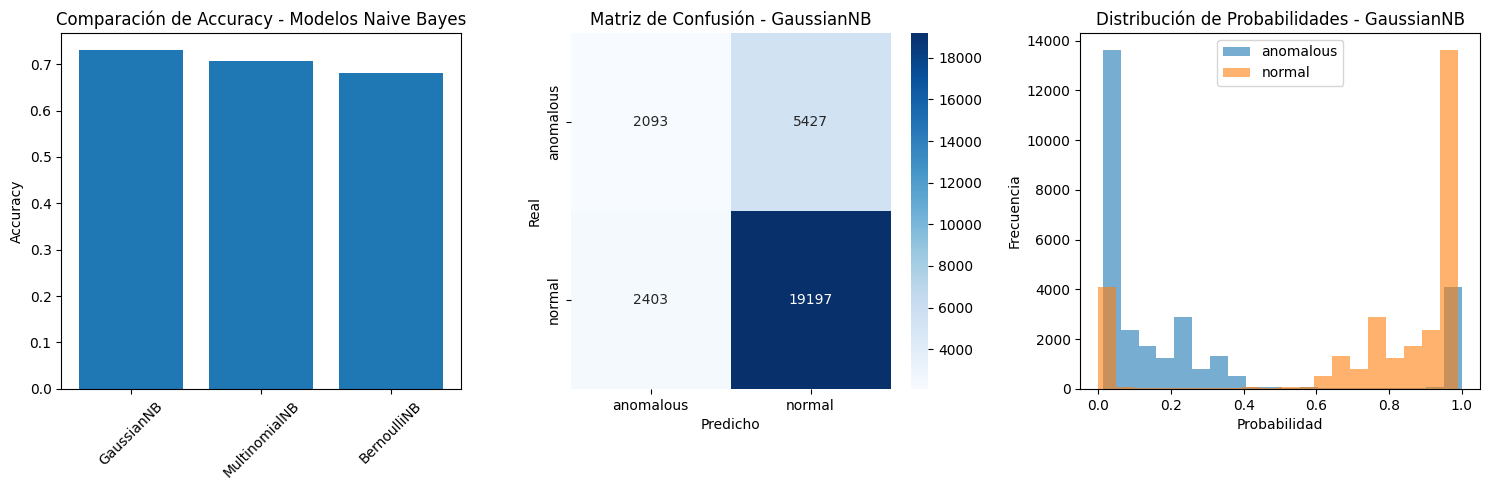


Mejor modelo: GaussianNB


In [18]:
def evaluate_and_visualize(results, y_test, target_encoder):
    """
    Evaluar y visualizar resultados de los modelos
    """
    # Comparar accuracy
    accuracies = {name: result['accuracy'] for name, result in results.items()}
    
    plt.figure(figsize=(15, 5))
    
    # Gráfico 1: Comparación de accuracy
    plt.subplot(1, 3, 1)
    plt.bar(accuracies.keys(), accuracies.values())
    plt.title('Comparación de Accuracy - Modelos Naive Bayes')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    
    # Gráfico 2: Matriz de confusión del mejor modelo
    best_model_name = max(accuracies, key=accuracies.get)
    best_predictions = results[best_model_name]['predictions']
    
    plt.subplot(1, 3, 2)
    cm = confusion_matrix(y_test, best_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_encoder.classes_,
                yticklabels=target_encoder.classes_)
    plt.title(f'Matriz de Confusión - {best_model_name}')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    
    # Gráfico 3: Distribución de probabilidades (solo para GaussianNB)
    plt.subplot(1, 3, 3)
    if 'GaussianNB' in results:
        gaussian_model = results['GaussianNB']['model']
        probabilities = gaussian_model.predict_proba(X_test)
        
        for i, class_name in enumerate(target_encoder.classes_):
            plt.hist(probabilities[:, i], alpha=0.6, label=class_name, bins=20)
        
        plt.title('Distribución de Probabilidades - GaussianNB')
        plt.xlabel('Probabilidad')
        plt.ylabel('Frecuencia')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return best_model_name

# Evaluar resultados
best_model = evaluate_and_visualize(results, y_test, target_encoder)
print(f"\nMejor modelo: {best_model}")

## 6. Modelo Final y Predicciones

In [19]:
def train_final_model(X, y, model_type='GaussianNB'):
    """
    Entrenar modelo final con todos los datos
    """
    if model_type == 'GaussianNB':
        model = GaussianNB()
    elif model_type == 'MultinomialNB':
        model = MultinomialNB()
    elif model_type == 'BernoulliNB':
        model = BernoulliNB()
    else:
        raise ValueError("Tipo de modelo no válido")
    
    model.fit(X, y)
    return model

# Entrenar modelo final
final_model = train_final_model(X, y, best_model)

# Función para hacer predicciones en nuevos datos
def predict_new_request(request_features, model, encoders, target_encoder):
    """
    Predecir clase para una nueva solicitud HTTP
    """
    # Preprocesar las features de la nueva solicitud
    # (aquí necesitarías implementar la misma lógica de preprocesamiento)
    # ...
    
    prediction = model.predict([request_features])[0]
    probability = model.predict_proba([request_features])[0]
    
    predicted_class = target_encoder.inverse_transform([prediction])[0]
    
    print(f"Clase predicha: {predicted_class}")
    print("Probabilidades:")
    for i, class_name in enumerate(target_encoder.classes_):
        print(f"  {class_name}: {probability[i]:.4f}")
    
    return predicted_class, probability

# Características importantes del modelo
print("\n=== ANÁLISIS DEL MODELO ===")
print(f"Modelo final: {best_model}")
print(f"Número de features: {X.shape[1]}")
print(f"Clases: {target_encoder.classes_}")

if hasattr(final_model, 'theta_'):
    print("\nMedias por clase (primeras 5 features):")
    for i, class_name in enumerate(target_encoder.classes_):
        print(f"  {class_name}: {final_model.theta_[i][:5]}")


=== ANÁLISIS DEL MODELO ===
Modelo final: GaussianNB
Número de features: 11
Clases: ['anomalous' 'normal']

Medias por clase (primeras 5 features):
  anomalous: [ 0.4138839   0.          0.         97.6117694   0.42194295]
  normal: [ 0.22222222  0.          0.         70.00133333  0.5       ]


## 7. Guardar el Modelo

In [20]:
import joblib

# Guardar modelo y preprocesadores
model_artifacts = {
    'model': final_model,
    'label_encoders': encoders,
    'target_encoder': target_encoder,
    'feature_names': X.columns.tolist()
}

joblib.dump(model_artifacts, 'naive_bayes_http_model.pkl')
print("Modelo guardado como 'naive_bayes_http_model.pkl'")

# Para cargar el modelo posteriormente:
# loaded_artifacts = joblib.load('naive_bayes_http_model.pkl')
# model = loaded_artifacts['model']

Modelo guardado como 'naive_bayes_http_model.pkl'
